In [1]:
import matplotlib.pyplot as plt
import scipy
from tqdm.notebook import tqdm
from numba import njit
from jax import grad, jit, vmap
import jax.numpy as jnp
import jax
from scipy.optimize import fmin, minimize_scalar, minimize, root_scalar
import numpy as np

%load_ext autoreload
%autoreload 2

Import the package with all the integrals function

In [2]:
from integrals import *

### Changing h to fix m


In [3]:
m=0.1
e = -0.7
q=m
p=3
h_new = root_scalar(
                lambda h: compute_m_FP(m,q, h, p, e) - m, bracket=[-10, 10]
            ).root
compute_m_FP(m,q, h_new, p, e)

0.09999999999980745

In [7]:
p=5
blend = 0.8
Teqs = np.array([0.58, 0.60695, 0.62, 0.64, 0.66, 0.68, 0.7001, 0.72])
es = -1/(2*Teqs)

ms = np.linspace(0.0, 0.99, 1_000)
Temps = np.empty((len(es), len(ms)))
qs = np.empty((len(Temps), len(ms)))
hs = np.empty((len(Temps), len(ms)))
fs = np.empty((len(Temps), len(ms)))
deltafs = np.empty((len(Temps), len(ms)))
entropys = np.empty((len(Temps), len(ms)))

for jdx, e in enumerate(tqdm(es)):
    for idx, m in enumerate(ms):
        err = 1
        q = m
        h = 0.1

        while err > 1e-7:
            h_new = root_scalar(
                lambda h: compute_m_FP(m, q, h, p, e) - m, bracket=[-10, 10]
            ).root
            q_new = compute_q_FP(m, q, h_new, p,e)

            err = max(abs(h_new - h), abs(q_new - q))
            h = blend * h + (1 - blend) * h_new
            q = blend * q + (1 - blend) * q_new

        qs[jdx, idx] = q
        hs[jdx, idx] = h
        Temps[jdx, idx] = 1/beta_q_e(q,m, e)
        fs[jdx, idx] = f_FP(m, q, h, p, e)
        deltafs[jdx, idx] = deltaf_FP(m, q, h, p, e)
        entropys[jdx, idx] = s_FP(m, q, h, p, e)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
Teqs = np.array([0.58, 0.60695, 0.62, 0.64, 0.66, 0.68, 0.7001, 0.72])
Teqs_list = [str(x) for x in Teqs.tolist()]


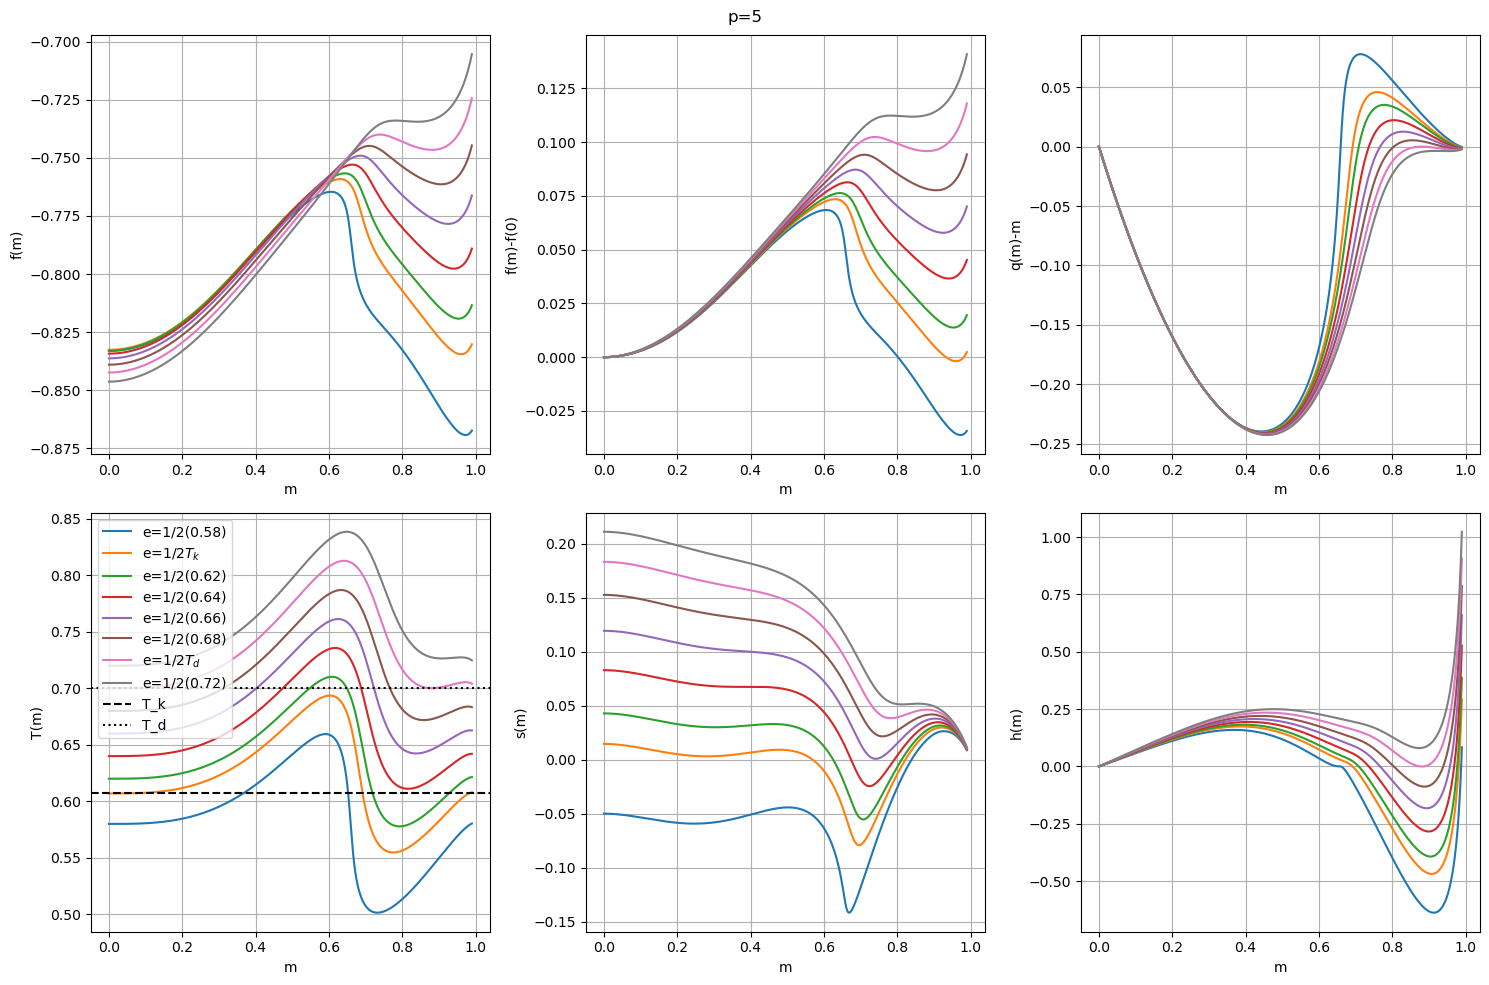

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f'p={p}')
e_string = ['1/2('+str(x)+')' for x in Teqs.tolist()]
e_string[1] = r'$1/2T_k$'
e_string[-2] = r'$1/2T_d$'
for jdx, e in enumerate(es):
    axs[0,0].plot(ms, fs[jdx,:], '-', label=f'e={e_string[jdx]}')
    axs[0,1].plot(ms, deltafs[jdx,:], '-', label=f'e={e_string[jdx]}')
    #ax[2].plot(ms, es, '-', label=f'T={T}')
    axs[0,2].plot(ms, qs[jdx,:]-ms, '-', label=f'e={e_string[jdx]}')
    #ax[3].plot(ms, ms, 'k--', label=f'y=x')
    axs[1,0].plot(ms, Temps[jdx,:], '-', label=f'e={e_string[jdx]}')
    axs[1,1].plot(ms, entropys[jdx,:], '-', label=f'e={e_string[jdx]}')
    axs[1,2].plot(ms, hs[jdx,:], '-', label=f'e={e_string[jdx]}')

axs[0,0].set_ylabel('f(m)')
axs[0,1].set_ylabel('f(m)-f(0)')
axs[0,2].set_ylabel('q(m)-m')
axs[1,0].set_ylabel('T(m)')
axs[1,0].axhline(0.60695, color='k', linestyle='--', label='T_k')
axs[1,0].axhline(0.7001, color='k', linestyle=':', label='T_d')
axs[1,1].set_ylabel('s(m)')
axs[1,2].set_ylabel('h(m)')
axs[0,0].set_xlabel('m')
axs[0,1].set_xlabel('m')
axs[0,2].set_xlabel('m')
axs[1,0].set_xlabel('m')
axs[1,1].set_xlabel('m')
axs[1,2].set_xlabel('m')
axs[1,0].legend(loc='upper left')

axs[0,0].grid()
axs[0,1].grid()
axs[0,2].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[1,2].grid()
plt.tight_layout()
fig.savefig(f'FPpspin_p{p}.png')

### Find $T_{sh}$

(-0.02, 0.02)

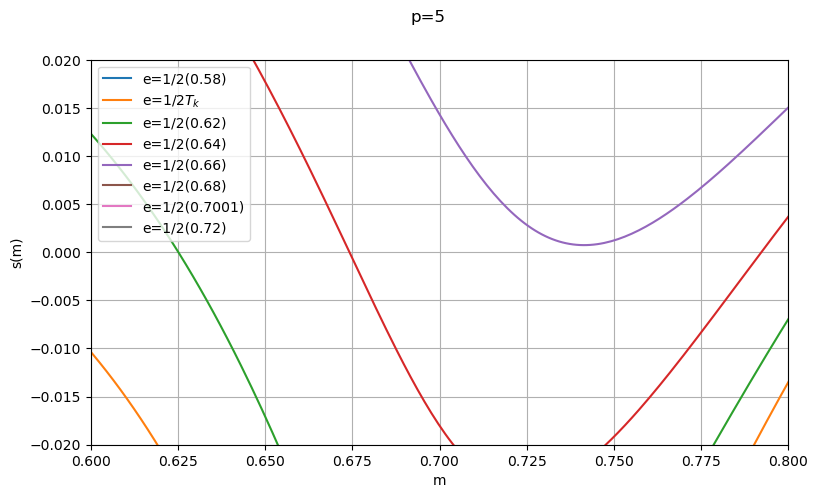

In [20]:
# Plot s(m) as the plot above

fig, ax = plt.subplots(1, 1, figsize=(9, 5))
fig.suptitle(f'p={p}')  
for jdx, e in enumerate(es):
    ax.plot(ms, entropys[jdx,:], '-', label=f'e={e_string[jdx]}')
ax.set_ylabel('s(m)')
ax.set_xlabel('m')
ax.legend()
ax.grid()

ax.set_xlim(0.6, 0.8)
ax.set_ylim(-0.02, 0.02)


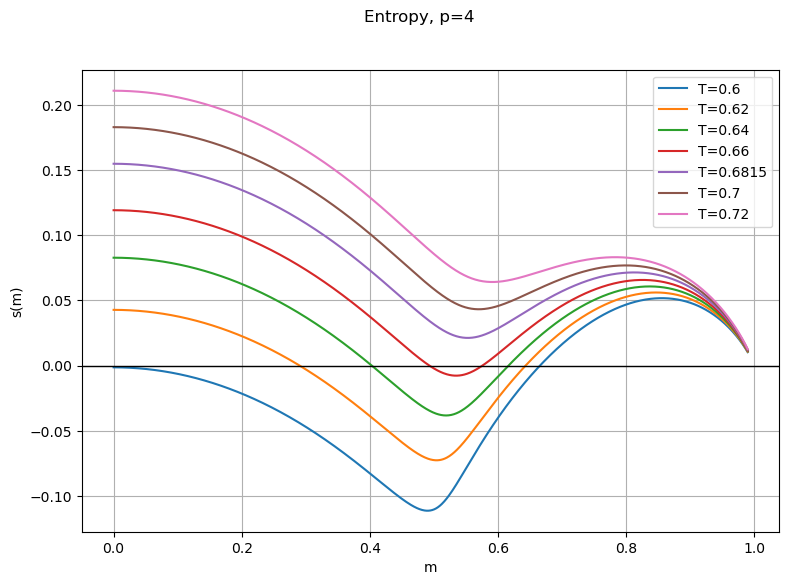

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
fig.suptitle(f'Entropy, p={p}')
for jdx, T in enumerate(Temps):
    ax.plot(ms, entropys[jdx,:], '-', label=f'T={T}')
ax.set_xlabel('m')
ax.set_ylabel('s(m)')
ax.axhline(0, color='black', lw=1)
ax.legend()
ax.grid()

### Definition of the functions

Gradient of the function    

In [6]:
@njit()
def smooth_function(x, e1, e2):
    if x < 1:
        return x ** e1
    else:
        return x ** e2

def fun_to_min_scipy(x, m, e, exp1, exp2):
    J0 = x[0]
    q = x[1]
    if q > 1 or q < 0:
        return 1e15
    return (
        smooth_function(abs(m - compute_m(m, J0, q, e)), exp1, exp2)
        + smooth_function(abs(q - compute_q(m, J0, q, e)), exp1, exp2)
    )

In [7]:
x_init = np.array([8.85, 0.009])
x_init = np.array([10, 0.14])
m = 0.5
e = -0.2

res = fmin(
    fun_to_min_scipy, x0=x_init, args=(m, e, 0.5, 2), xtol=1e-10, full_output=True
)

print(res)

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 103
         Function evaluations: 193
(array([1.82614507, 0.2592403 ]), 4.65840797082507e-06, 103, 193, 0)


Fixed E sweep in m

In [5]:
e = -0.8
ms = np.linspace(0.01, 1.0, 10_000)
x_init = np.array([25, 0.0001])

m_valid = []
s_tab = []
beta_tab = []

for idx, m in enumerate(tqdm(ms)):
    res = fmin(
        fun_to_min_scipy,
        x0=x_init,
        args=(m, e, 0.7, 2),
        xtol=1e-13,
        disp=False,
        full_output=True,
    )
    x_init = res[0]
    J0 = x_init[0]
    q = x_init[1]

    try:
        beta = beta_q_e(q, e)
    except:
        print("beta problem")
        break

    if res[1] > 1e-7:
        print("m = ", m, " did not converge, error = ", res[1])
        print("J0 = ", J0, " q = ", q, " beta = ", beta)
        break

    s = compute_s(m, J0, q, e)

    m_valid.append(m)
    s_tab.append(s)
    beta_tab.append(beta)

  0%|          | 0/10000 [00:00<?, ?it/s]

m =  0.5708910891089108  did not converge, error =  5.197178986688962e-06
J0 =  0.7901727953720576  q =  0.9998483465151049  beta =  3517.3225576637396


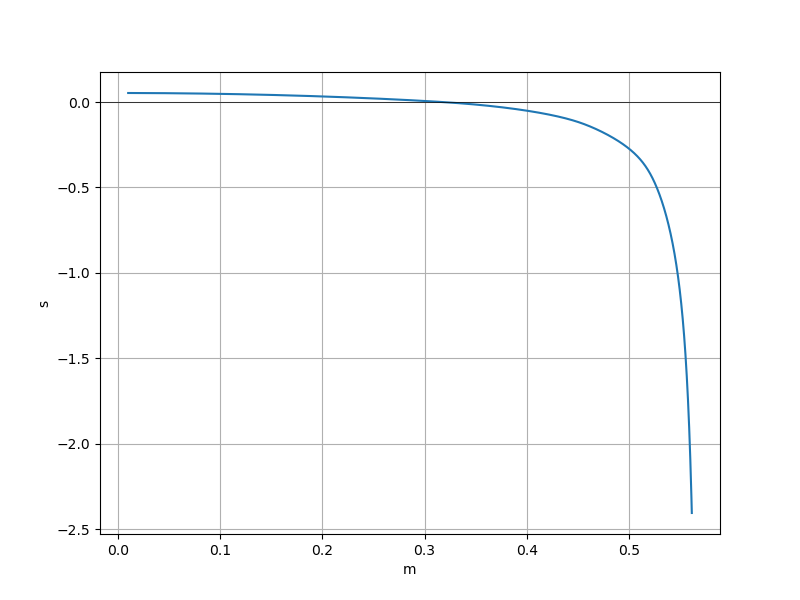

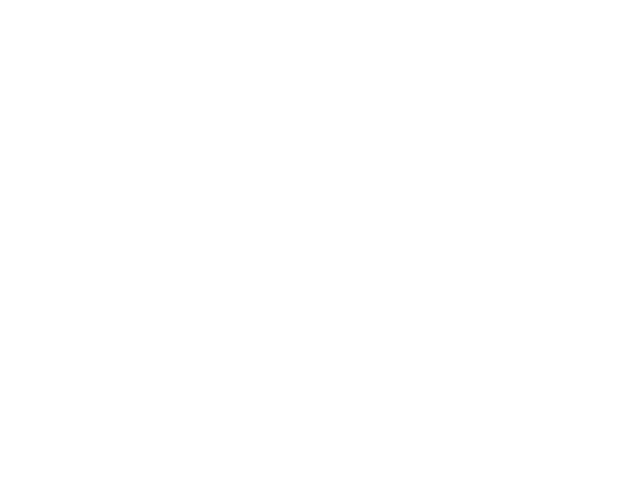

In [6]:
plt.clf()
plt.figure(figsize=(8, 6))

plt.plot(m_valid, s_tab)

plt.axhline(0, color='black', lw=0.5)
plt.xlabel("m")
plt.ylabel("s")
plt.grid()
plt.show()


In [7]:
print(m_valid[-5:])
print(s_tab[-5:])

[0.5703960396039603, 0.5704950495049504, 0.5705940594059405, 0.5706930693069306, 0.5707920792079207]
[inf, inf, inf, inf, inf]


### Sweep of $q$ solution as function of $J0$

In [70]:
e = -0.3
m = 0.9

In [129]:
blend = 0.4
J0s = np.linspace(0.0, 0.8, 20_000)

J0s_valid = []
q_valid = []

q_init_0 = 0.994

dif_es = np.linspace(-0.3, -0.8, 20)

for e in tqdm(dif_es):
    J0_tmp = []
    q_tmp = []
    for idx, J0 in enumerate(J0s):
        err = 1
        q = q_init
        while err > 1e-15:
            q_new = compute_q(m, J0, q, e)

            q = blend * q_new + (1 - blend) * q
            err = abs(q - q_new)

        q_init = q

        J0_tmp.append(J0)
        q_tmp.append(q)

    J0s_valid.append(J0_tmp)
    q_valid.append(q_tmp)

  0%|          | 0/20 [00:00<?, ?it/s]

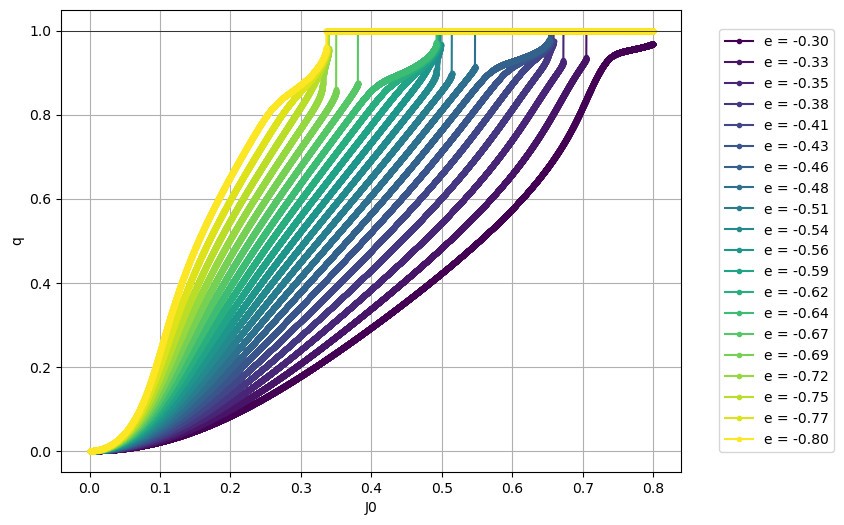

In [135]:
plt.figure(figsize=(8, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(dif_es)))
for idx, (e, c) in enumerate(zip(dif_es, colors)):
    plt.plot(J0s_valid[idx], q_valid[idx], ".-", label=f"e = {e:.2f}", color=c)

plt.axhline(1, color='black', lw=0.5)

plt.xlabel("J0")
plt.ylabel("q")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
# plt.ylim(0.9,1)
# plt.xlim(0.3,0.8)
plt.grid()

plt.show()

### Sweeps of $J0$ as a function of $q$

In [171]:
e = -0.3
m = 0.8

In [172]:
qs = np.linspace(0.1, 0.999, 1_000)
J0_init = 0.1

J0s_valid = []
q_valid = []

J0_init_0 = 0.1

dif_es = np.linspace(-0.3, -0.7, 15)


@njit()
def fun_to_min(x, m, q, e):
    J0 = x[0]
    added_term = 0.0
    if J0 < 0:
        added_term = 1e3
    return abs(q - compute_q(m, J0, q, e)) ** 1.5 + added_term


for e in tqdm(dif_es):
    J0s_tmp = []
    q_tmp = []

    for idx, q in enumerate(qs):
        res = minimize(
            fun_to_min,
            x0=J0_init,
            tol=1e-11,
            args=(m, q, e),
        )

        J0_init = res.x[0]

        if res.fun > 1e-10:
            print("q = ", q, " did not converge, error = ", res.fun)
            print("J0 = ", res.x[0])
            break

        J0s_tmp.append(res.x[0])
        q_tmp.append(q)

    J0s_valid.append(J0s_tmp)
    q_valid.append(q_tmp)

    q0s_second = np.array(q_valid)
    J0s_second = np.array(J0s_valid)

  0%|          | 0/15 [00:00<?, ?it/s]

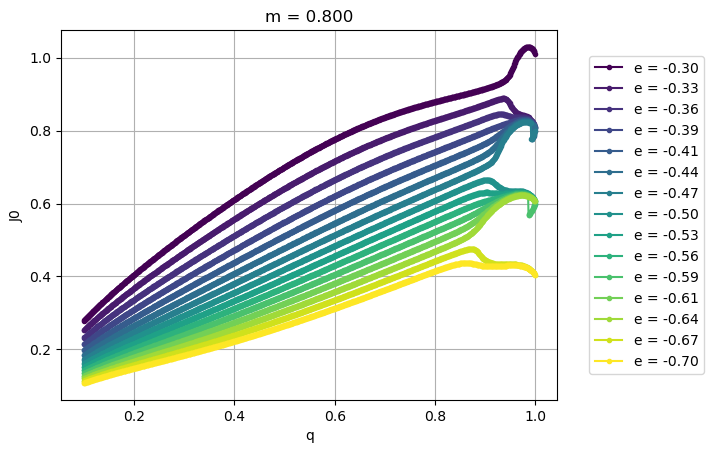

In [173]:
colors = plt.cm.viridis(np.linspace(0, 1, len(dif_es)))
for idx, (e, c) in enumerate(zip(dif_es, colors)):
    plt.plot(q_valid[idx], J0s_valid[idx], ".-", label=f"e = {e:.2f}", color=c)

plt.title(f"m = {m:.3f}")
plt.xlabel("q")
plt.ylabel("J0")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
# plt.xlim(0.8,1)
# plt.ylim(0.27,0.35)
plt.grid()

plt.show()

### Check which of the solutions is also solving first equation

In [47]:
value_first_residual = np.empty_like(q0s_second)

for idx, (q, J0) in enumerate(zip(q0s_second, J0s_second)):
    value_first_residual[idx] = abs(m - compute_m(m, J0, q, e))

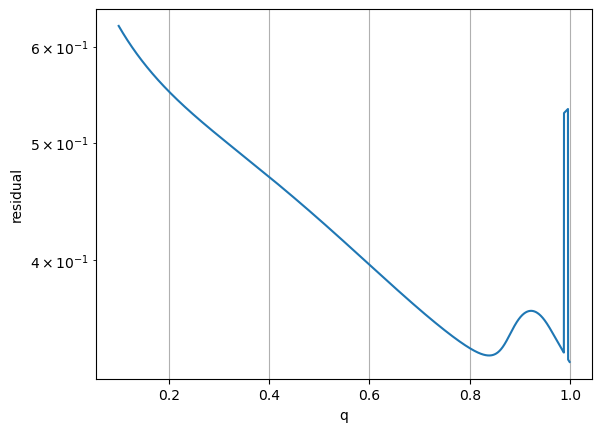

In [49]:
plt.plot(q0s_second, value_first_residual)
plt.xlabel("q")
plt.ylabel("residual")
plt.yscale("log")
plt.grid()

plt.show()

### Others

Functions for the iterations

In [15]:
def iterate_q(m, J0, q0, e, verbose=False):
    q_old = q0 + 1e-5
    q = q0
    while abs(q_old - q) > 1e-6:
        q_old = q
        q = compute_q(m, J0, q, e)
        if verbose:
            print(q)
    return q


def find_m(m, e, q0, J00, verbose=False):
    q = iterate_q(m, J00, q0, e, verbose=verbose)
    m = compute_m(m, J00, q, e)
    return m  # ,J00,q,e

### Simulations

##### Let's try the fixed point iterations

In [16]:
m = 0.9
J0 = 0.1
e = -0.7
q0 = 0.1

q = iterate_q(m, J0, q0, e, verbose=True)

0.12492006440313871
0.13446955081873394
0.13861921230170082
0.1405032864415323
0.14137456405027193
0.14178079718654238
0.1419709172802272
0.14206005054113802
0.14210187268086313
0.1421215035195885
0.14213071966660418
0.14213504676237107
0.1421370784680261
0.142138032434545


#### 1) Bifurcation routine

##### Let's try the iterations functions

In [17]:
m = 0.9
J0 = 0.1
e = -0.7
q0 = 0.5
find_m(m, e, q0, J0, verbose=False)

0.31257509942014294

In [18]:
m = 0.8
e = -0.2
q0 = 0.5
J0star = scipy.optimize.root(lambda J0: find_m(m, e, q0, J0) - m, 1.0).x[0]
q = iterate_q(m, J0star, q0, e)
m = compute_m(m, J0star, q, e)
beta = beta_q_e(q, e)
s = compute_s(m, J0star, q, e)
print(m, J0star, q, e, beta, s)

0.8 1.1498726106181565 0.6692432055703005 -0.2 0.5712204641532995 0.2695592224886201


##### Loop:

  0%|          | 0/4 [00:00<?, ?it/s]

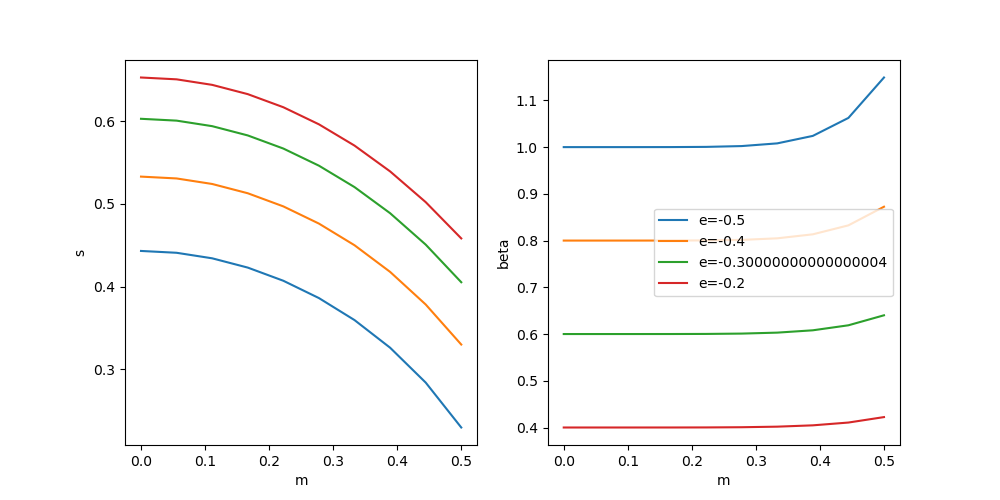

In [19]:
# We plot s(m) and beta(m) for different e

s_tab = np.zeros((4,10))
beta_tab = np.zeros((4,10))
for i,e in tqdm(enumerate(np.linspace(-0.5,-0.2,4)),total=4):
    for j,m in enumerate(np.linspace(0.,0.6,10)):
        q0=0.5
        J0star = scipy.optimize.root(lambda J0: find_m(m,e,q0,J0)-m, 0.1).x[0]
        q = iterate_q(m,J0star,q0,e)
        beta = beta_q_e(q,e)
        s = compute_s(m,J0star,q,e)
        s_tab[i,j] = s
        beta_tab[i,j] = beta

fig,ax = plt.subplots(1,2,figsize=(10,5))
for i in range(4):
    ax[0].plot(np.linspace(0.,0.5,10),s_tab[i,:],label='e='+str(np.linspace(-0.5,-0.2,4)[i]))
    ax[0].set_xlabel('m')
    ax[0].set_ylabel('s')   
    ax[1].plot(np.linspace(0.,0.5,10),beta_tab[i,:],label='e='+str(np.linspace(-0.5,-0.2,4)[i]))
    ax[1].set_xlabel('m')
    ax[1].set_ylabel('beta')
plt.legend()